In [1]:
# In case you want to change the deepxde default backend just run the following line and select the backend at the end of the line:
# source: https://www.kaggle.com/code/lucasscheink/tesis-2d

# !python /Users/vassilis/anaconda3/pkgs/deepxde-1.9.3-pyhd5b0024_0/site-packages/deepxde/backend/set_default_backend.py tensorflow

In [2]:
import deepxde as dde
import numpy as np
import pandas as pd
import scipy as sp
from math import exp
#import tensorflow as tf
from deepxde.backend import tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import os
import time

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
os.getcwd()

'/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/Hyperparameters_tuning/Final_train'

Here we define the parameters that we want to estimate.

Now we can begin by creating a TimeDomain class.

In [4]:
geom = dde.geometry.TimeDomain(0, 56*24)

In [5]:
# Function to estimate the constant parameters of the model
def create_params(substance, Texp):
    # Transform input temperature into Kelvin scale
    Texp = 273 + Texp  # K

    Tref = 273 + np.array([6, 12, 18])  # Reference Temperature K - Grech et al. 2018
    keep_ref_value = np.argmin(np.abs(Tref - Texp))

    # Cardiac output reference value at T = 6 C (Barron et al. 1987, Table II)
    F_card_ref_6 = 1.188  # ml/h/g
    # Cardiac output reference value at T = 12 C (Barron et al. 1987, Table II)
    F_card_ref_12 = 2.322  # ml/h/g
    # Cardiac output reference value at T = 18 C (Barron et al. 1987, Table II)
    F_card_ref_18 = 3.75  # ml/h/g
    F_card_ref_values = [F_card_ref_6, F_card_ref_12, F_card_ref_18]
    F_card_ref = F_card_ref_values[keep_ref_value]

    # Body weight reference value at T = 6 C (Barron et al. 1987, Table II)
    BW_ref_6 = 270.1  # g
    # Body weight reference value at T = 12 C (Barron et al. 1987, Table II)
    BW_ref_12 = 296.4  # g
    # Body weight reference value at T = 18 C (Barron et al. 1987, Table II)
    BW_ref_18 = 414.5  # g
    BW_ref_values = [BW_ref_6, BW_ref_12, BW_ref_18]
    BW_ref = BW_ref_values[keep_ref_value]

    # Arrhenius Temperature function
    TA = 6930  # Arrhenius Temperature K - Grech et al. 2018
    Tr = Tref[np.argmin(np.abs(Tref - Texp))]
    KT = exp(TA / Tr - TA / Texp)

    # Load the xlsx file with the physiological params of rainbow trout
    phys_params_sheet1 = pd.read_excel('/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/Rainbow trout Physiological parameters/Rainbow trout Physiological parameters.xlsx', sheet_name=0)

    # Keep only the physiological parameters from the paper of Vidal et al. 2019
    fw = phys_params_sheet1.loc[phys_params_sheet1['Source'] == 'Vidal et al. 2019', ['Liver', 'Blood', 'Skin', 'Muscle', 'Gills', 'Kidney', 'Viscera']]
    fw_Liver = fw['Liver'].values[0]
    fw_Blood = fw['Blood'].values[0]
    fw_Skin = fw['Skin'].values[0]
    fw_Muscle = fw['Muscle'].values[0]
    fw_Gills = fw['Gills'].values[0]
    fw_Kidney = fw['Kidney'].values[0]
    fw_Viscera = fw['Viscera'].values[0]
    fw_lumen = 0.012

    # Load the xlsx file with the physiological params of rainbow trout
    phys_params_sheet2 = pd.read_excel('/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/Rainbow trout Physiological parameters/Rainbow trout Physiological parameters.xlsx', sheet_name=1)

    # Keep only the physiological parameters from the paper of Vidal et al. 2019
    fb = phys_params_sheet2.loc[phys_params_sheet2['Source'] == 'Vidal et al. 2019', ['Liver', 'Skin', 'Muscle', 'Gills', 'Kidney', 'Viscera']]
    fb_Liver = fb['Liver'].values[0]
    fb_Skin = fb['Skin'].values[0]
    fb_Muscle = fb['Muscle'].values[0]
    fb_Gills = fb['Gills'].values[0]
    fb_Kidney = fb['Kidney'].values[0]
    fb_Viscera = fb['Viscera'].values[0]

    # Reabsorption coefficients from bile to intestine
    # estimated by Cao et al., 2022
    # K_urine = Cl_urine / f_reab_urine estimated by Ng et al., 2013 (unitless)
    if substance == 'PFOA':
        a = 0.138  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.30  # Cao et al., 2022
        K_urine = 2.08
        Cl_urine = 0.029 * 3600  # 1/h (Sun et al., 2022)
    elif substance == 'PFNA':
        a = 0.522  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.34  # Cao et al., 2022
        K_urine = 1.35
        Cl_urine = 0.050 * 3600  # 1/h (Sun et al., 2022)
    elif substance == 'PFBS':
        a = 0.0598  # Goeritz et al. 2013
        f_reab_hep = 0.23  # Cao et al., 2022
        K_urine = 5.88
        Cl_urine = 0.023 * 3600  # 1/h (Sun et al., 2022) # Assumed equal to PFHxS
    elif substance == 'PFHxS':
        a = 0.558  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.30  # Cao et al., 2022
        K_urine = 5.88
        Cl_urine = 0.023 * 3600  # 1/h (Sun et al., 2022)
    elif substance == 'PFOS':
        a = 0.721  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.42  # Cao et al., 2022
        K_urine = 1.35
        Cl_urine = 0.050 * 3600  # 1/h (Sun et al., 2022)

    # Bile flow coefficient
    Q_bile_coef = 7.5e-05  # ml/g BW/h Grosell et al., 2000
    Q_urine_coef = 2.755e-03  # ml/h/g of BW Urinary flow rate (Curtis et al., 1981)
    V_urine_coef = 2.2e-03  # ml/g of BW Urine volume inside urinary bladder (Curtis et al., 1981)

    a_skin = 0.9  # 90% of venous blood of skin was assumed to flow directly to kidney (Nichols et al. 1996)
    a_muscle = 0.6  # 60% of venous blood of muscle was assumed to flow directly to kidney (Nichols et al. 1996)

    plasma = 0.7
    
    return[F_card_ref, BW_ref, KT, fw_Liver, fw_Blood, fw_Skin, fw_Muscle, fw_Gills, fw_Kidney,
          fw_Viscera, fw_lumen, fb_Liver, fb_Skin, fb_Muscle, fb_Gills, fb_Kidney, fb_Viscera,
          a_skin, a_muscle, Q_bile_coef, Q_urine_coef, V_urine_coef, 
          K_urine, Cl_urine, f_reab_hep,plasma,a]

In [6]:
def fish_weight(time):
    x = tf.constant([0, 28 * 24, 56 * 24], dtype=tf.float32)
    y = tf.constant([314, 655, 808], dtype=tf.float32)

    w = tf.zeros([1,1])

    for time_i in tf.unstack(time):
        time_i = tf.cast(time_i, 'float32')
        condition_1 = tf.math.less_equal(time_i, tf.cast(x[0], 'float32'))
        condition_2 = tf.math.greater_equal(time_i, tf.cast(x[2], 'float32'))
        condition_3 = tf.math.logical_and(tf.math.greater_equal(time_i, tf.cast(x[0], 'float32')), tf.math.less(time_i, tf.cast(x[1], 'float32')))
        condition_4 = tf.math.logical_and(tf.math.greater_equal(time_i, tf.cast(x[1], 'float32')), tf.math.less(time_i, tf.cast(x[2], 'float32')))
        
        w_new = tf.cond(condition_1, lambda: y[0], 
                         lambda: tf.cond(condition_2, lambda: y[2], 
                                         lambda: tf.cond(condition_3, 
                                                         lambda: tfp.math.interp_regular_1d_grid(tf.cast(time_i, 'float32'), tf.cast(x[0], 'float32'),  
                                                                 tf.cast(x[1], 'float32'), tf.cast(y[0:2], 'float32')), 
                                                         lambda: tfp.math.interp_regular_1d_grid(tf.cast(time_i, 'float32'), tf.cast(x[1], 'float32'), 
                                                                    tf.cast(x[2], 'float32'), tf.cast(y[1:3], 'float32')) ))) 
        
        w_new = tf.reshape(w_new, [-1,1])
        w = tf.concat([w, w_new], axis=0)   
    w = w[1:]
    return (w)

Next, we create the PBK model to solve using the dde.grad.jacobian function.

In [7]:
def PBK_model(t, net_out, ex):
    # At this point we estimate the derivatives of the networks outputs to time    
    M_art, M_venous, M_gills, M_lumen, M_lumen_2, M_viscera, M_liver, M_kidney, \
    M_muscle, M_skin, M_carcass, M_storage, M_urine, M_feces, M_blood = net_out[:, 0:1], net_out[:, 1:2], \
    net_out[:, 2:3], net_out[:, 3:4], net_out[:, 4:5], net_out[:, 5:6], net_out[:, 6:7], net_out[:, 7:8], \
    net_out[:, 8:9], net_out[:, 9:10], net_out[:, 10:11], net_out[:, 11:12], net_out[:, 12:13], net_out[:, 13:14], net_out[:, 14:15]
    
    dM_art_ls = dde.gradients.jacobian(net_out, t, i=0)
    dM_venous_ls = dde.gradients.jacobian(net_out, t, i=1)
    dM_gills_ls = dde.gradients.jacobian(net_out, t, i=2)
    dM_lumen_ls = dde.gradients.jacobian(net_out, t, i=3)
    dM_lumen_2_ls = dde.gradients.jacobian(net_out, t, i=4)
    dM_viscera_ls = dde.gradients.jacobian(net_out, t, i=5)
    dM_liver_ls = dde.gradients.jacobian(net_out, t, i=6)
    dM_kidney_ls = dde.gradients.jacobian(net_out, t, i=7)
    dM_muscle_ls = dde.gradients.jacobian(net_out, t, i=8)
    dM_skin_ls = dde.gradients.jacobian(net_out, t, i=9)
    dM_carcass_ls = dde.gradients.jacobian(net_out, t, i=10)
    dM_storage_ls = dde.gradients.jacobian(net_out, t, i=11)
    dM_urine_ls = dde.gradients.jacobian(net_out, t, i=12)
    dM_feces_ls = dde.gradients.jacobian(net_out, t, i=13)
    dM_blood_ls = dde.gradients.jacobian(net_out, t, i=14)

    
    #------------------------------------------------------------
    # Estimate the derivatives based on the ODEs.
    
    # Estimation of constant parameters 
    (F_card_ref,BW_ref,KT,fw_Liver,fw_Blood,fw_Skin,fw_Muscle,fw_Gills,
     fw_Kidney, fw_Viscera, fw_lumen,fb_Liver,fb_Skin,fb_Muscle,fb_Gills,
     fb_Kidney,fb_Viscera,a_skin,a_muscle,Q_bile_coef,
     Q_urine_coef,V_urine_coef,K_urine,Cl_urine,f_reab_hep,plasma, a) = create_params('PFOS', 15)
    
    CLU_coef = 0.0005719031
    Ku = 1.4668919575
    Cl_feces = 1.3064647362
    
    # Body weight - g
    BW = fish_weight(t)
        
    # Total cardiac output ml/h considered as plasma flow
    Q_total = F_card_ref*KT*(BW/BW_ref)**(-0.1)*BW*plasma  
    
    # Calculate the mass of each tissue - g
    w_blood = fw_Blood*BW*plasma     # Blood mass - g
    w_liver = fw_Liver*BW     # Liver mass - g
    w_skin = fw_Skin*BW       # Skin weight - g
    w_muscle = fw_Muscle*BW   # Muscle weight - g
    w_gills = fw_Gills*BW     # Gills weight - g
    w_kidney = fw_Kidney*BW   # Kidney weight - g
    w_viscera = fw_Viscera*BW # Viscera weight - g
    w_lumen = fw_lumen*BW
    w_art = 1/3*w_blood
    w_venous = 2/3*w_blood
    w_carcass = BW - (w_blood/plasma + w_liver + w_skin + w_muscle +
                         w_gills + w_kidney + w_viscera + w_lumen)
    
    # Calculate the regional blood flows - ml/h
    Q_liver = fb_Liver*Q_total     # Liver blood flow - ml/h
    Q_skin = fb_Skin*Q_total       # Skin blood flow - ml/h
    Q_muscle = fb_Muscle*Q_total   # Muscle blood flow - ml/h
    Q_gills = Q_total              # Gills blood flow - ml/h
    Q_kidney = fb_Kidney*Q_total   # Kidney blood flow - ml/h
    Q_viscera = fb_Viscera*Q_total # Viscera blood flow - ml/h
    Q_carcass = Q_total - (Q_liver + Q_skin + Q_muscle + 
                              Q_kidney + Q_viscera)
    
    # Calculate the absolute bile flow rate - ml/h
    Q_bile = Q_bile_coef*BW
    # Calculate Urinary flow rate - ml/h
    Q_urine = Q_urine_coef*BW
    
    # Calculate urine volume  - ml 
    v_urine = V_urine_coef*BW
    
    # Calculate f_reab_urine based on Cl_urine and K_urine - 1/h
    f_reab_urine = Cl_urine*CLU_coef/K_urine
    
    # Tissue concentrations ug PFAS/g tissue
    C_gills = M_gills/w_gills
    C_viscera = M_viscera/w_viscera
    C_liver = M_liver/w_liver
    C_kidney = M_kidney/w_kidney
    C_muscle = M_muscle/w_muscle 
    C_skin = M_skin/w_skin
    C_carcass = M_carcass/w_carcass
    C_lumen = (M_lumen+M_lumen_2)/w_lumen
    C_art = M_art/w_art
    C_venous = M_venous/w_venous
    C_blood = (M_art + M_venous)/w_blood
    C_storage = M_storage/v_urine
    
    # Arterial Blood
    dM_art_rs = Q_gills*C_gills/P_gills - \
                (Q_viscera + Q_liver + Q_kidney + 
                 Q_muscle + Q_skin + Q_carcass)*C_art
        
    # Venous blood    
    dM_venous_rs = - Q_total*C_venous + \
                    (Q_liver + Q_viscera)*C_liver/P_liver + \
                    (Q_kidney + a_muscle*Q_muscle + a_skin*Q_skin)*C_kidney/P_kidney + \
                    (1-a_muscle)*Q_muscle*C_muscle/P_muscle + \
                    (1-a_skin)*Q_skin*C_skin/P_skin + Q_carcass*C_carcass/P_carcass
    
    dM_blood_rs = (dM_art_rs + dM_venous_rs)*plasma
    
    # Gills 
    dM_gills_rs = Q_gills*(C_venous - C_gills/P_gills) 
    
    # Viscera Lumen - Available PFAS for absorption and elimination
    dM_lumen_rs = - Ku*a*M_lumen - Cl_feces*(1-a)*M_lumen + ex
    
    # Viscera Lumen 2 - Unavailable PFAS for absorption. Can be only eliminated.
    dM_lumen_2_rs = (1-f_reab_hep)*Q_bile*C_liver - Cl_feces*M_lumen_2 
    
    
    # Viscera Tissue
    dM_viscera_rs = Q_viscera*(C_art - C_viscera/P_viscera) + Ku*a*M_lumen + \
                      f_reab_hep*Q_bile*C_liver
    
    # Liver
    dM_liver_rs = Q_liver*C_art + Q_viscera*C_viscera/P_viscera -    \
                      (Q_liver + Q_viscera)*C_liver/P_liver - Q_bile*C_liver
        
    # Kidney
    dM_kidney_rs = Q_kidney*C_art -   \
                  (Q_kidney + a_muscle*Q_muscle + a_skin*Q_skin)*C_kidney/P_kidney + \
                  a_muscle*Q_muscle*C_muscle/P_muscle +   \
                  a_skin*Q_skin*C_skin/P_skin - Cl_urine*CLU_coef*M_kidney + f_reab_urine*M_storage
    
                
    # Muscle 
    dM_muscle_rs = Q_muscle*(C_art - C_muscle/P_muscle)

    # Skin
    dM_skin_rs = Q_skin*(C_art - C_skin/P_skin)
    
    # Carcass 
    dM_carcass_rs = Q_carcass*(C_art - C_carcass/P_carcass)
    
    # Urine Storage
    dM_storage_rs = Cl_urine*CLU_coef*M_kidney - f_reab_urine*M_storage - Q_urine*C_storage
    
    # Urine
    dM_urine_rs = Q_urine*C_storage
    
    # Feces
    dM_feces_rs = Cl_feces*((1-a)*M_lumen + M_lumen_2)
    
    return [
        dM_art_ls - dM_art_rs,
        dM_venous_ls - dM_venous_rs,
        dM_gills_ls - dM_gills_rs,
        dM_lumen_ls - dM_lumen_rs,
        dM_lumen_2_ls - dM_lumen_2_rs,
        dM_viscera_ls - dM_viscera_rs,
        dM_liver_ls - dM_liver_rs,
        dM_kidney_ls - dM_kidney_rs,
        dM_muscle_ls - dM_muscle_rs,
        dM_skin_ls - dM_skin_rs,
        dM_carcass_ls - dM_carcass_rs,
        dM_storage_ls - dM_storage_rs,
        dM_urine_ls - dM_urine_rs,
        dM_feces_ls - dM_feces_rs,
        dM_blood_ls - dM_blood_rs,
        M_blood - (M_art + M_venous),
        M_lumen - abs(M_lumen),
        M_lumen_2 - abs(M_lumen_2),
        M_urine - abs(M_urine),
        M_feces - abs(M_feces),
        M_storage - abs(M_storage)
    ]

Next, we consider the initial conditions. We need to implement a function, which should return True for points inside the subdomain and False for the points outside.

In [8]:
def boundary(_, on_initial):
    return on_initial

In [9]:
def gen_traindata(data_path):
    #data = np.load('PFOS_dataset.npy')
    data = pd.read_csv(data_path)
    return np.vstack(data["Time"]), np.vstack(data["Liver"]), np.vstack(data["Blood"]), np.vstack(data["Skin"]), \
            np.vstack(data["Muscle"]), np.vstack(data["Gills"]), np.vstack(data["Kidney"]), np.vstack(data["Carcass"])

In [10]:
data_path = '/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/Hyperparameters_tuning/PFOS_Mass_dataset.csv'
pd.read_csv(data_path)

,Unnamed: 0,Substance,Time,Cumulative_added_PFAS,Feeding_period,Depuration_period,Liver,Blood,Skin,Muscle,Gills,Kidney,Carcass
0,2,PFOS,168,31.89875,168,0,0.830824,1.387634,0.902924,6.333805,0.282163,0.387887,1.211752
1,3,PFOS,336,71.55525,336,0,1.774949,2.223234,1.642856,7.884101,0.405304,0.828127,2.063702
2,4,PFOS,672,174.14150,672,0,3.641293,4.908156,3.974353,19.320693,0.773400,1.674786,5.364159
3,5,PFOS,744,174.14150,0,72,3.044344,4.249679,3.064818,10.004054,0.678865,1.419006,3.782428
4,6,PFOS,840,174.14150,0,168,2.810464,2.984789,3.299889,7.602470,0.759248,1.136403,4.472106
5,7,PFOS,1008,174.14150,0,336,1.702425,2.084880,1.480999,4.976324,0.445934,0.649347,2.062184
6,8,PFOS,1344,174.14150,0,672,1.812408,1.067025,0.895023,1.934924,0.341851,0.387848,1.197082


In [11]:
observe_t, Obs_liver, Obs_blood, Obs_skin, Obs_muscle, Obs_gills, Obs_kidney, Obs_carcass = gen_traindata(data_path)

observe_Blood = dde.icbc.PointSetBC(observe_t, Obs_blood, component=14, shuffle=False) 
observe_Gills = dde.icbc.PointSetBC(observe_t, Obs_gills, component=2, shuffle=False)
observe_Liver = dde.icbc.PointSetBC(observe_t, Obs_liver, component=6, shuffle=False)
observe_Kidney = dde.icbc.PointSetBC(observe_t, Obs_kidney, component=7, shuffle=False)
observe_Muscle = dde.icbc.PointSetBC(observe_t, Obs_muscle, component=8, shuffle=False)
observe_Skin = dde.icbc.PointSetBC(observe_t, Obs_skin, component=9, shuffle=False)
observe_Carcass = dde.icbc.PointSetBC(observe_t, Obs_carcass, component=10,shuffle=False)

## Events data. Define Auxiliary function to model the added amount of PFAS.

In [12]:
events_data = pd.read_csv('/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/Hyperparameters_tuning/events_simplified.csv')
time_points = np.vstack(events_data['time'])
added_amount = np.vstack(events_data['value'])

def ex_func(t): 
    added_pfas = []
    for time_i in t:
        if np.isin(time_i, time_points):
            index = np.where(np.isin(time_points, time_i))
            added_pfas.append(added_amount[index])
        else:
            added_pfas.append(0)
    return(np.vstack(added_pfas))

# def ex_func(t): 
#     added_pfas = []
#     for time_i in t:
#         if time_i <= 648:
#             added_pfas.append(6.449685/24)
#         else:
#             added_pfas.append(0)
#     return(np.vstack(added_pfas))

In [13]:
print(events_data.shape)
print(time_points.shape)
print(added_amount.shape)

(28, 2)
(28, 1)
(28, 1)


In [14]:
anchors = observe_t
anchors = np.sort(anchors, axis=0)
anchors = np.vstack(np.unique(anchors))

## Output transform function.

In [15]:
def output_transform(t, netout):
    netout1 = netout[:, 0:1]
    netout2 = netout[:, 1:2]
    netout3 = netout[:, 2:3]
    netout4 = netout[:, 3:4]
    netout5 = netout[:, 4:5]
    netout6 = netout[:, 5:6]
    netout7 = netout[:, 6:7]
    netout8 = netout[:, 7:8]
    netout9 = netout[:, 8:9]
    netout10 = netout[:, 9:10]
    netout11 = netout[:, 10:11]
    netout12 = netout[:, 11:12]
    netout13 = netout[:, 12:13]
    netout14 = netout[:, 13:14]
    netout15 = netout[:, 14:15]
    
    return tf.concat(
        [netout1 * tf.tanh(t) , netout2 * tf.tanh(t), netout3 * tf.tanh(t),
         netout4 * tf.tanh(t), 
         netout5 * tf.tanh(t), netout6 * tf.tanh(t),
         netout7 * tf.tanh(t) , netout8 * tf.tanh(t), netout9 * tf.tanh(t),
         netout10 * tf.tanh(t), netout11 * tf.tanh(t), netout12 * tf.tanh(t),
         netout13 * tf.tanh(t), netout14 * tf.tanh(t), netout15 * tf.tanh(t)
        ], axis=1
    )

In [16]:
"""
Initialize the parameters values

"""
def initialize_params():
    P_liver = dde.Variable(1.0)
    P_muscle = dde.Variable(1.0)
    P_kidney = dde.Variable(1.0)
    P_skin = dde.Variable(1.0)
    P_gills = dde.Variable(1.0)
    P_carcass = dde.Variable(1.0)
    P_viscera = dde.Variable(1.0)
    external_trainable_variables = [P_liver,P_muscle,P_kidney,P_skin,P_gills,P_carcass,P_viscera]
    return(external_trainable_variables)

def train_PINN(data_loss_weight, external_trainable_variables, N_hidden=5, N_neurons=30,
               N_collocation=500, iterations=600000, lr=0.001):
    
    # path to load weights
    #path_weights = "/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/Hyperparameters_tuning/model_18/model.ckp-269000.ckpt"
    # path to save new results
    path_save = "/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/Hyperparameters_tuning/Final_train"
    os.chdir(path_save)

    data = dde.data.PDE(
        geometry = geom, # Instance of Geometry
        pde = PBK_model, # A global PDE or a list of PDEs. None if no global PDE.
        bcs = [observe_Blood, observe_Gills, observe_Liver, observe_Kidney,
               observe_Muscle, observe_Skin, observe_Carcass], #A boundary condition or a list of boundary conditions. Use [] if no boundary condition.
        num_domain=N_collocation, # The number of training points sampled inside the domain.
        #num_test= 10, 
        num_boundary=7, # The number of training points sampled on the boundary.
        #train_distribution = 'uniform', # The distribution to sample training points.
        anchors=anchors, # A Numpy array of training points, in addition to the num_domain and num_boundary sampled points.
        auxiliary_var_function = ex_func)

    """
    Feed-Forward Neural Network.
    Initilize the neural network constant parameters (initializer, activation function,
    learning rate, optimizer, loss function, external trainable parameters and loss weights)
    """

    initializer = tf.keras.initializers.GlorotUniform(seed = None)
    loss_weights = np.concatenate((np.repeat([1.0], 21), np.repeat([data_loss_weight],7)) )
    optimizer = tf.keras.optimizers.Adam()
    lr=lr
    loss = dde.losses.mean_squared_error
    iterations = iterations

    """
    Set up and compile the NN

    """

    model_name = 'final_model'
    variable = dde.callbacks.VariableValue(external_trainable_variables, period=500, filename= (model_name + '.dat'), precision = 5)

    #early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-06, patience=100000, baseline=None, monitor='loss_train')

    checkpointer = dde.callbacks.ModelCheckpoint(
    filepath= path_save + '/model.ckp',
    verbose=1, save_better_only=True, period=1, monitor='train loss')

    net = dde.nn.FNN([1] + [N_neurons] * N_hidden + [15], "tanh", initializer)
    net.apply_output_transform(output_transform)
    model = dde.Model(data, net)
    model.compile(optimizer = optimizer, lr=lr, loss = loss, loss_weights = loss_weights.tolist(),
                  external_trainable_variables=external_trainable_variables)

    """
    Train the PINN

    """

    losshistory, train_state = model.train(iterations=iterations, callbacks=[variable,checkpointer])
    dde.saveplot(losshistory, train_state, issave=True, isplot = True)

    test_data = np.genfromtxt('test.dat',
                         skip_header=0,
                         skip_footer=0,
                         names=None,
                         dtype=None,
                         delimiter=' ')
    columns_names=['Time', 'M_art', 'M_venous', 'M_gills', 'M_lumen', 'M_lumen_2', 'M_viscera', 'M_liver', 'M_kidney', \
                    'M_muscle', 'M_skin', 'M_carcass', 'M_storage', 'M_urine', 'M_feces', 'M_blood']
    test_df = pd.DataFrame(test_data, columns = columns_names)
    test_df.to_csv((model_name + '_preds'+ '.csv'), sep=',')

    return()


Compiling model...
'compile' took 0.000212 s

Training model...



/Users/vassilis/anaconda3/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2023-10-03 17:20:44.072527: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Step      Train loss                                                                                                                                                                                                                                                                                  Test loss                                                                                                                                                                                                                                                                                   Test metric
0         [1.08e+04, 6.35e+03, 8.77e+02, 1.31e+00, 3.77e-01, 4.29e+01, 6.58e+00, 4.89e+02, 2.67e+03, 3.51e+01, 1.00e+02, 2.50e-02, 3.60e-02, 7.16e-01, 2.90e+02, 2.04e-02, 0.00e+00, 0.00e+00, 0.00e+00, 1.68e+00, 0.00e+00, 1.09e+00, 6.64e-02, 6.88e-01, 4.68e-02, 9.65e+00, 6.51e-01, 1.02e+00]    [1.08e+04, 6.35e+03, 8.77e+02, 1.31e+00, 3.77e-01, 4.29e+01, 6.58e+00, 4.89e+02, 2.67e+03, 3.51e+01, 1.00e+02, 2.50e

2023-10-03 17:21:40.815914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradients/fnn/strided_slice_grad/StridedSliceGrad_grad/StridedSlice/gradients/fnn/strided_slice_grad/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradients/fnn/strided_slice_grad/StridedSliceGrad_grad/StridedSlice/gradients/fnn/strided_slice_grad/StridedSliceGrad/strides}}]]
2023-10-03 17:21:40.816731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradients/fnn/strided_slice_1_grad/StridedSliceGrad_grad/StridedSlice/gradients/fnn/strided_slice_1_grad/StridedSliceGrad/strides' with dtype int

Epoch 1: train loss improved from inf to 2.17e+04, saving model to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/Hyperparameters_tuning/Final_train/model.ckp-1.ckpt ...

1000      [4.30e-03, 4.38e-03, 3.14e-03, 5.79e-01, 4.33e-05, 1.49e-04, 1.71e-02, 2.00e-03, 6.22e-03, 3.92e-03, 7.32e-03, 1.26e-04, 6.16e-06, 2.41e-04, 2.91e-03, 5.76e-02, 4.98e-05, 9.89e-05, 0.00e+00, 0.00e+00, 5.02e-06, 7.46e-01, 2.66e-02, 5.63e-01, 1.01e-01, 7.47e+00, 5.32e-01, 8.40e-01]    [4.30e-03, 4.38e-03, 3.14e-03, 5.79e-01, 4.33e-05, 1.49e-04, 1.71e-02, 2.00e-03, 6.22e-03, 3.92e-03, 7.32e-03, 1.26e-04, 6.16e-06, 2.41e-04, 2.91e-03, 5.76e-02, 4.98e-05, 9.89e-05, 0.00e+00, 0.00e+00, 5.02e-06, 7.46e-01, 2.66e-02, 5.63e-01, 1.01e-01, 7.47e+00, 5.32e-01, 8.40e-01]    []  
Epoch 1000: train loss improved from 2.17e+04 to 1.10e+01, saving model to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/Hyperparameters_tu

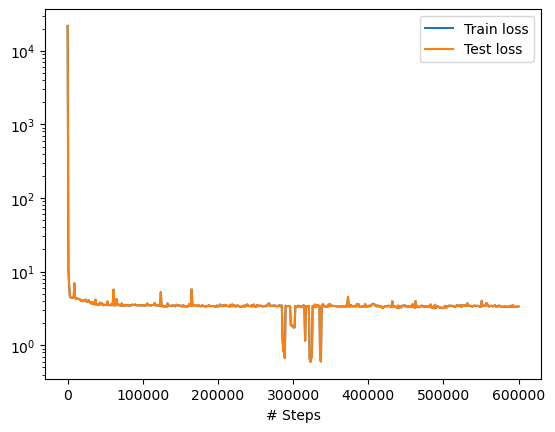

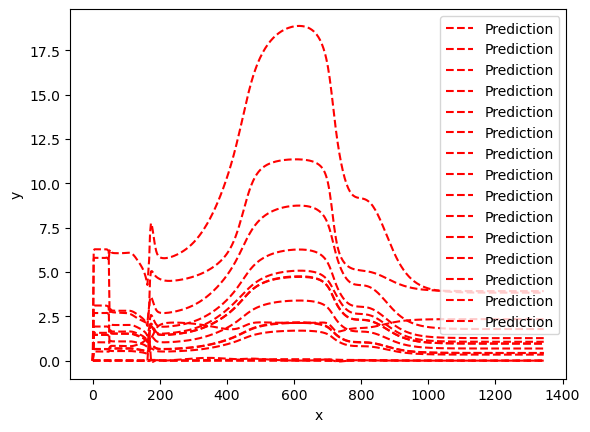

()

In [17]:
P_liver,P_muscle,P_kidney,P_skin,P_gills,P_carcass,P_viscera = initialize_params()
external_trainable_variables = [P_liver,P_muscle,P_kidney,P_skin,P_gills,P_carcass,P_viscera]

train_PINN(data_loss_weight = 0.1, external_trainable_variables = external_trainable_variables)

## Take predictions

In [18]:
# path to save new results
path_save = '/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/Hyperparameters_tuning/Final_train/predictions'
os.chdir(path_save)

data = dde.data.PDE(
    geometry = geom, # Instance of Geometry
    pde = PBK_model, # A global PDE or a list of PDEs. None if no global PDE.
    bcs = [observe_Blood, observe_Gills, observe_Liver, observe_Kidney,
           observe_Muscle, observe_Skin, observe_Carcass], #A boundary condition or a list of boundary conditions. Use [] if no boundary condition.
    num_domain=500, # The number of training points sampled inside the domain.
    #num_test= 10, 
    num_boundary=7, # The number of training points sampled on the boundary.
    #train_distribution = 'uniform', # The distribution to sample training points.
    anchors=anchors, # A Numpy array of training points, in addition to the num_domain and num_boundary sampled points.
    auxiliary_var_function = ex_func)

"""
Feed-Forward Neural Network.
Initilize the neural network constant parameters (initializer, activation function,
learning rate, optimizer, loss function, external trainable parameters and loss weights)
"""

initializer = tf.keras.initializers.GlorotUniform(seed = None)
loss_weights = np.concatenate((np.repeat([1.0], 21), np.repeat([100],7)) )
optimizer = tf.keras.optimizers.Adam()
lr=0.001
loss = dde.losses.mean_squared_error
iterations = 200000
external_trainable_variables = initialize_params()

time_points = np.arange(0,1345,1.0)
time_points = np.vstack(time_points)

In [19]:
net = dde.nn.FNN([1] + [30] * 5 + [15], "tanh", initializer)
net.apply_output_transform(output_transform)
model = dde.Model(data, net)
model.compile(optimizer = optimizer, lr=lr, loss = loss, external_trainable_variables=external_trainable_variables)
# path to load weights
path_weights = '/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/Hyperparameters_tuning/Final_train/model.ckp-218000.ckpt'
model.restore(save_path=path_weights, verbose=1)

preds = model.predict(time_points)
preds=np.hstack((time_points, preds))
columns_names=['Time','M_art', 'M_venous', 'M_gills', 'M_lumen', 'M_lumen_2', 'M_viscera', 'M_liver', 'M_kidney', \
                    'M_muscle', 'M_skin', 'M_carcass', 'M_storage', 'M_urine', 'M_feces', 'M_blood']
preds_df = pd.DataFrame(preds, columns = columns_names)
preds_df.to_csv('final_predictions.csv', sep=',', index=False)

Compiling model...
'compile' took 0.000383 s

Restoring model from /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/Hyperparameters_tuning/Final_train/model.ckp-218000.ckpt ...



NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/Hyperparameters_tuning/Final_train/model.ckp-218000.ckpt